# Duckietown - Reinforcement Learning based on World Models

## OpenAI Gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like CarRacing or Pacman.
https://gym.openai.com/


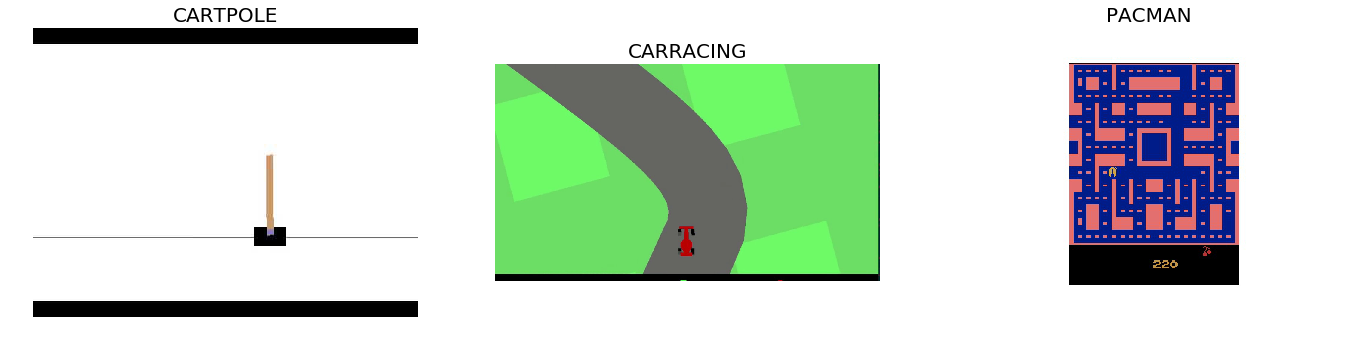

In [21]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

names = ['CARTPOLE', 'CARRACING', 'PACMAN']
images = []
for img_path in glob.glob('C://Users//Tony Stark//Desktop//Deep Learning a Gyakorlatban//Házi//img//*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure("ENVIRONMENTS", figsize=(40,40))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(names[i], fontsize=20)
    


## Duckietown Gym 



Duckietown is a playful learning experience for state-of-the-art robotics and AI. It makes it possible to develop and test state-of-the-art autonomous driving algorythms with Deep Learning in a joyful sandbox environment. To make the development faster, the Duckietown Foundation published the Duckietown Simulator based on the OpenAI Gym environment: https://github.com/duckietown/gym-duckietown .



In order to use the Gym environment we have to install and import the gym package. The installation can be performed by running the following code in command prompt: 

In [ ]:
git clone https://github.com/openai/gym.git
cd gym
pip install -e .

The detailed installation guide can be found on the following github repository: https://github.com/openai/gym .

After that the Duckietown environment also has to be installed:

In [ ]:
git clone https://github.com/duckietown/gym-duckietown.git
cd gym-duckietown
pip3 install -e .

Further information can be found on the original GitHub repository: https://github.com/duckietown/gym-duckietown .

A simple Duckietown environment can be created by the following code:

In [ ]:
import gym
import numpy as np

env = gym.make(“Duckietown-udem1-v0”)
env.reset()

action = np.array([0.6, 0.1])

for i in range(10000):
    env.render()
    observation, reward, done, info = env.step(action)
    
env.close()

**1.) gym.make(“ENVIRONMENT NAME”) :** returns (and creates) the environment that was passed as parameter. There are several maps in Duckietown Gym, 'udem1-v0' is just one of them.

**2.) env.reset():** This command resets and initializes the environment and returns with an initial observation.

**3.) for _ in range(1000):** This line in python code will run an instance of ‘Duckietown-udem1-v0’ environment for 1000 timesteps.

**4.) env.render():** This command displays the current state of the environment in a popup window. Since it is written within a loop, an updated popup window will be rendered for every new action taken in each step.

**5.) env.step():** This command takes an action at each step. The action is a numpy array with two float elements that are in the range of [-1.0 , +1.0]. The first and second elements represent the velocity (move forward / backward), and the angle of the steering wheel (move right / left) respectively. The function returns four parameters, namely observation, reward, done and info. These four are explained below:

**a) observation:** an environment-specific image (numpy array) representing your observation of the environment.

**b) reward:** the amount of reward achieved by the previous action. It is a floating data type value and the default reward function tries to encourage the agent to drive forward along the right lane in each tile.

**c) done:** A boolean value stating whether it’s time to reset the environment again.

**d) info (dict):** diagnostic information useful for debugging.



## World Models

Our task is to implement the World Models (that was basically used on the OpenAI CarRacing environment) into the Duckietown environment. In the following chapter the architecture of the model will be briefly introduced. For further information please visit https://worldmodels.github.io/ .

### Architecture

World Models has 3 basic components:

In [1]:
%%HTML 
<img src="pic/world_models.png",width=600,height=600>

**1.) Vision (V):** The Vision model is a Convolutional Variational Autoencoder (VAE) which takes an observation (2D image) from the environment and encodes it into a latent vector 'z' of size 32.

The architecture of the VAE network is shown below:

In [2]:
%%HTML 
<img src="pic/VAE.png",width=60,height=60, align="center">

**2.) Memory (M):** A Recurrent Neural Network with Mixture Density Network takes the latent vector 'z' from the vision module, the previous action 'a' chosen by the controller and the previous hidden state 'h' of itself. Similarly to the vision module, it’s goal is to capture a latent understanding/observation of the environment by predicting what would the next 'z' look like.

The architecture of the Memory RNN network is shown below:

In [3]:
%%HTML 
<img src="pic/RNN.png",width=60,height=60, align="center">

**3.) Controller (C):** In the original implementation it is a simple single layer linear model which maps the vision module’s observation 'z' and the memory module’s hidden state 'h' to an action 'a' at each time step. The output will be an action-vector (numpy array) of size 2 containing the quantitative representation of the velocity [-1.0 to 1.0] and the angle of the steering wheel [-1.0 to 1.0]. 

The simple linear model which is trained to take the best decision is as follows:

In [4]:
%%HTML 
<img src="pic/controller.png",width=60,height=60, align="center">

In our implementation we change the simple linear model to a more advanced algorythm called Proximal Policy Optimization (PPO):
https://openai.com/blog/openai-baselines-ppo/

## Training the network

### VAE

In the first step, the VAE network will be trained independently in the following way:

1.) The network takes an image with a size of (H x W x C) as input.

2.) A convolutional network creates a 'z' vector of length 32 as a compressed representation of the input image.

3.) A deconvolutional network then takes the 'z' vector as input and generates a (H x W x C) sized image as an output.

4.) Finally the VAE network computes the loss based on the similarity of the input (original) and the output (generated) images. (If the two images are quite similar, that means that the VAE learned to compress images efficiently into a vector of length 32.)

Note that the deconvolutional network will only be used during training, after that it will be 'deactivated'.

In order to speed up the training process of the VAE we generated a dataset of 2000 images from the Duckietown Gym environment. For this purpose we used and modified the 'manual_control.py' file to save the actual observation (numpy array) from the environment in every step as a '.png' image. The modified file can be found in our Github repository as 'vae_dataset_generator.py'. (The reason we used the 'manual_control.py' is that we wanted to generate a diverse dataset.)

To generate the images it is necessary to modify the path to the saving folder. If it is done then run the 'vae_dataset_generator.py' in an IDE or use the following code in the terminal:

In [ ]:
python vae_dataset_generator.py --env-name Duckietown-udem1-v0

### Memory

Before training this network, we will first fix the parameters of the VAE (we do not want it to train any more).

The RNN takes two inputs in every step: the current 'z' vector from the VAE and the previous action 'a' chosen by the controller. 

During the training of the RNN, we will use a simple random number generator (that generates two numbers in the range of [-1.0, +1.0]) to simulate the controller (due to the fact that it will not have been trained yet). The output of the RNN is the predicted 'z' value of the next step ('z+1'), so that the loss will be calculated based on the similarity of the current output of the RNN and the input from the VAE in the next step.

### Controller

Finally we will train the controller, but before that, we will first fix all the parameters of both the VAE and the Memory networks. 

The controller takes two vectors as input, one from the VAE (the current 'z' vector) and one from the Memory (the hidden 'h' vector) and generates an action 'a' as an output. 

Based on the action of the controller, the environment generates a reward (a float number) that indicates how good decision the controller has made. The aim of the controller is to maximize the reward it gets.